In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/FundamentalLearningEPFL/Homeworks/HW3

/content/drive/MyDrive/FundamentalLearningEPFL/Homeworks/HW3


# $\color{Green}{\text{Fundamentals of Inference and Learning}}$
Name: Roduit \
Surname : Vincent \
Sciper: 325140

Again, as said in Homework 1, only relevant steps of the calculation are written in this notebook. The full derivation can be found in the PDF file attached to the submission
## Homework 3

### Exercise 1 : Backpropagation with logistic loss

In [3]:
import numpy as np

import torch
import torchvision
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%load_ext autoreload
%autoreload 2

1.

In [6]:
def sigmoid(t):
    """Compute the sigmoid function.
    Args:
        t (np.ndarray): Input array of any shape
    Returns:
        np.ndarray, sigmoid function applied to input array
    """
    return 1 / (1 + np.exp(-t))

In [7]:
def predict(X,W):
    """ Compute the prediction
    Args :
        X (np.array): input data of shape (B,D)
        Dictionary W (dict): dictionary of weights (W={w 1: D x K, w 2: K x 1})
    Returns:
        tuple of np.ndarray, z_1, z_2, y_hat
    """
    z_1 = np.dot(X,W['w1'])
    x_1 = sigmoid(z_1)
    z_2 = np.dot(x_1,W['w2'])
    y_hat = sigmoid(z_2)
    return (z_1,z_2,y_hat)

2.

In [8]:
def logistic_loss(y, y_hat):
    """ Compute the logistic loss function
    Args :
        y (np.array): input data of shape (B,1)
        y_hat (np.array): input data of shape (B,1)
    Output :
        loss (float): logistic loss
    """
    return -np.mean(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))

In [9]:
B = 10
y = np.zeros(B)
y_hat = np.zeros(B)
loss = logistic_loss(y, y_hat)
print(f'The loss is  L = {loss:.4f}')

The loss is  L = nan


In this case, the loss is NaN beacuse the logarithm of 0 is not define ! The definition of the logistic loss is not stable. This problem will be assess in 3.

3.

We need to derive another expression for the loss:
$$
\mathcal{L}(y,\hat{y}) = -ylog(\hat{y}) - (1-y) * log(1-\hat{y})
$$
With $ \hat{y} = \frac{1}{1 + e^{-z_2}}$, the loss can be written as:
$$
\mathcal{L}(y,\hat{y}) = ylog(1 + e^{-z_2}) - (1-y)[log(e^{-z_2})-log(1 + e^{-z_2})] = log(1 + e^{-z_2}) + (1-y)z_2
$$

In [10]:
def stable_logistic_loss(y, z_2):
    """ Compute the logistic loss function
    Args :
        y (np.array): input data of shape (B,1)
        z_2 (np.array): input data of shape (B,1)
    Output :
        loss (float): logistic loss
    """
    return np.mean(np.logaddexp(0,-z_2) + (1-y)*z_2)

In [11]:
z_2 = -10e10 * np.ones(B)
y = np.zeros(B)

loss = stable_logistic_loss(y, z_2)
print(f'The loss is: L={loss:.2f}')

The loss is: L=0.00


Now the logistic loss is stable and the result corresponds to what we expected since there is no more undefined log !

4.

We need to compute :
$$
\frac{\partial \mathcal{L}(\mathbb{x};y;\mathbb{w})}{\partial w_{i,j}^{(1)}} = \frac{\partial \mathcal{L}}{\partial z_i^{(2)}} \frac{\partial z_i^{(2)}}{\partial z_i^{(1)}} \frac{\partial z_i^{(1)}}{\partial w_{i,j}^{(1)}}
$$
And
$$
\frac{\partial \mathcal{L}(\mathbb{x};y;\mathbb{w})}{\partial w_{i}^{(2)}} = \frac{\partial \mathcal{L}}{\partial z_i^{(2)}} \frac{\partial z_i^{(2)}}{\partial w_{i}^{(2)}}
$$

Let's compute each term:
* $\frac{\partial \mathcal{L}}{\partial z_i^{(2)}} = \hat{y} - y$
* $\frac{\partial z_i^{(2)}}{\partial z_i^{(1)}} = w_i^{(2)} * \sigma(z_i^{(1)})(1-\sigma(z_i^{(1)}))$
* $\frac{\partial z_i^{(1)}}{\partial w_{i,j}^{(1)}} = x^{(0)}$
* $ \frac{\partial z_i^{(2)}}{\partial w_{i}^{(2)}} = x^{(1)}$

Wich finally gives:
$$
\frac{\partial \mathcal{L}(\mathbb{x};y;\mathbb{w})}{\partial w_{i,j}^{(1)}} = (\hat{y} - y) * w_i^{(2)} * \sigma(z_i^{(1)})(1-\sigma(z_i^{(1)})) *x^{(0)}
$$
$$
\frac{\partial \mathcal{L}(\mathbb{x};y;\mathbb{w})}{\partial w_{i}^{(2)}} = (\hat{y} - y) * x^{(1)}
$$

5.

In [12]:
def gradient(X,y,W):
    """ Compute the gradient of the logistic loss function
    Args :
        X (np.array): input data of shape (B,D)
        y (np.array): input data of shape (B,1)
        W (dict): dictionary of weights (W={w 1: D x K, w 2: K x 1})
    Output :
        grad (dict): dictionary of gradients (grad={w 1: D x K, w 2: K x 1})
    """
    z_1, z_2,y_hat = predict(X,W)
    grad = {}
    grad['w_1'] = np.dot(X.T, (((y_hat - y)*sigmoid(z_1)*(1-sigmoid(z_1))) * W["w2"].T))
    grad['w_2'] = np.dot(sigmoid(z_1).T,y_hat-y)
    return grad

In [13]:
#parameters
D = 7
K = 5
B = 10

#data
X = np.random.randn(B,D)
y = np.random.randint(2,size=(B,1))

#weights
W = {}
W['w1'] = np.random.randn(D,K)
W['w2'] = np.random.randn(K,1)

grad = gradient(X,y,W)

In [14]:
grad['w_1'].shape, grad['w_2'].shape

((7, 5), (5, 1))

With the last cell, one can observe that the size are correct, according to the theory.

### Exercise 2 : Classifying KMNIST using neural networks

In [15]:
from training_utils import *

In [16]:
#parameters
NUM_TRAIN_DATA = 50000
NUM_VAL_DATA = 10000

BATCH_SIZE = 1024
TEST_BATCH_SIZE = 2048

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


1.

In order to use the datas with the further models in PyTorch, it is needed to transform the datas into tensors. This is done with the operation `torchvision.transforms.ToTensor()`

In [17]:
transform = torchvision.transforms.ToTensor()
# load the train dataset
train_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [18]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

It is necessary to transform the datas into tensors in order to use them into the neural networks

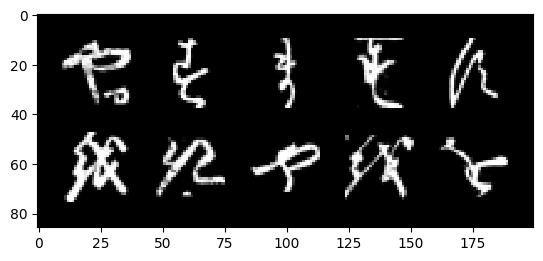

In [19]:
visualize_images(train_dataloader)

In [20]:
#defining the model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.lin1 = nn.Linear(28*28, 100)
        self.lin2 = nn.Linear(100, 100)
        self.lin3 = nn.Linear(100, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.lin1(x))
        x = self.relu(self.lin2(x))
        x = self.lin3(x)
        return x


In [21]:
mlp1 = MLP().to(DEVICE)
mlp2 = MLP().to(DEVICE)
mlp3 = MLP().to(DEVICE)
mlp4 = MLP().to(DEVICE)
list_mlp = [mlp1,mlp2,mlp3,mlp4]

list_optimizers = [
    torch.optim.SGD(mlp1.parameters(), lr=0.01),
    torch.optim.SGD(mlp2.parameters(), lr=0.01, momentum=0.9,nesterov=True),
    torch.optim.Adam(mlp3.parameters(), lr=0.01),
    torch.optim.Adam(mlp4.parameters(), lr=1)
]

tr_losses, val_losses, valid_accs, te_loss_all, te_accs = test_models(
    list_mlp,
    list_optimizers,
    train_dataloader,
    valid_dataloader,
    test_dataloader,
    DEVICE
    )

****** Model 1 **************
Epoch 0: Train Loss=2.3004, Validation Loss=2.2923, Validation acc=14.5700
Epoch 1: Train Loss=2.2871, Validation Loss=2.2784, Validation acc=16.1200
Epoch 2: Train Loss=2.2717, Validation Loss=2.2615, Validation acc=19.3800
Epoch 3: Train Loss=2.2525, Validation Loss=2.2396, Validation acc=25.9200
Epoch 4: Train Loss=2.2271, Validation Loss=2.2105, Validation acc=33.3800
Epoch 5: Train Loss=2.1932, Validation Loss=2.1714, Validation acc=41.1900
Epoch 6: Train Loss=2.1475, Validation Loss=2.1191, Validation acc=46.9500
Epoch 7: Train Loss=2.0872, Validation Loss=2.0514, Validation acc=47.8300
Epoch 8: Train Loss=2.0107, Validation Loss=1.9678, Validation acc=48.6200
Epoch 9: Train Loss=1.9190, Validation Loss=1.8710, Validation acc=49.9400
Epoch 10: Train Loss=1.8170, Validation Loss=1.7675, Validation acc=51.4700
Epoch 11: Train Loss=1.7124, Validation Loss=1.6653, Validation acc=53.0100
Epoch 12: Train Loss=1.6122, Validation Loss=1.5698, Validation acc=

In [22]:
values_task1 = {
    'tr_losses':tr_losses,
    'val_losses':val_losses,
    'valid_accs':valid_accs,
    'te_loss_all':te_loss_all,
    'te_accs':te_accs
}

In [23]:
test_acc = [tensor.item() for tensor in te_accs]
model_names = ['model1.1', 'model1.2', 'model1.3', 'model1.4']
descriptions = ['SGD + lr=0.01',
                'SGD + lr=0.01+ momentum=0.9 + nesterov=True',
                'Adam + lr=0.01',
                'Adam + lr = 1'
                ]
model_type = ['MLP'] * 4
results_task1 = pd.DataFrame({'Model': model_names,
                              'Model Type':model_type,
                              'Accuracy': test_acc,
                              'Description':descriptions})

In [24]:
results_task1

,Model,Model Type,Accuracy,Description
0,model1.1,MLP,53.129997,SGD + lr=0.01
1,model1.2,MLP,78.290001,SGD + lr=0.01+ momentum=0.9 + nesterov=True
2,model1.3,MLP,88.110001,Adam + lr=0.01
3,model1.4,MLP,9.990000,Adam + lr = 1


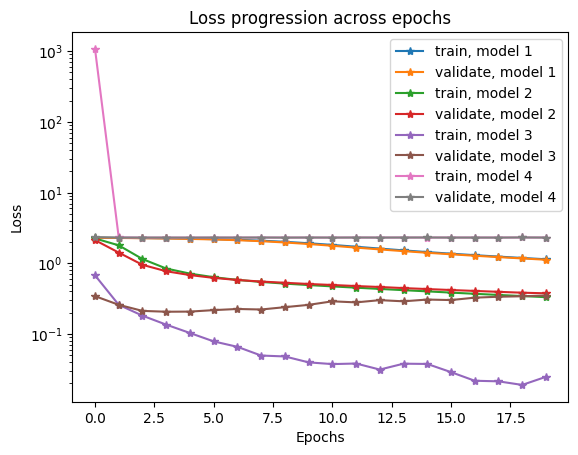

In [25]:
plot_losses(values_task1['tr_losses'],values_task1['val_losses'])

As it is difficult to see in one single plot, let see in different plots

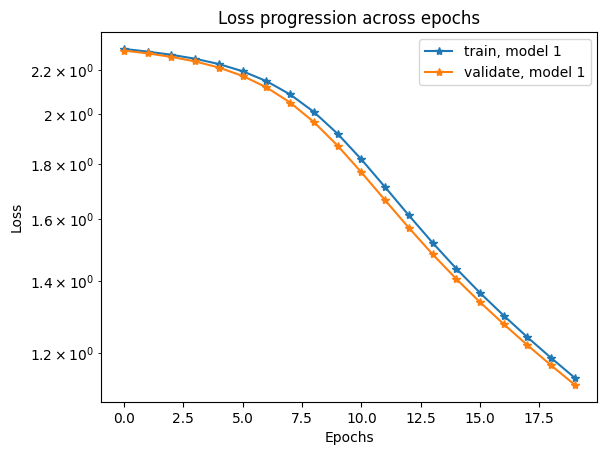

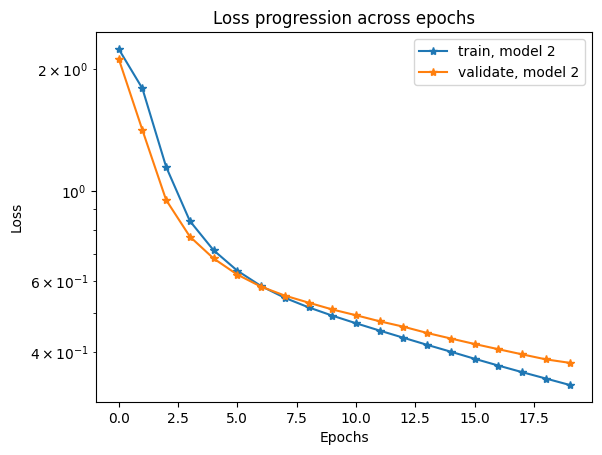

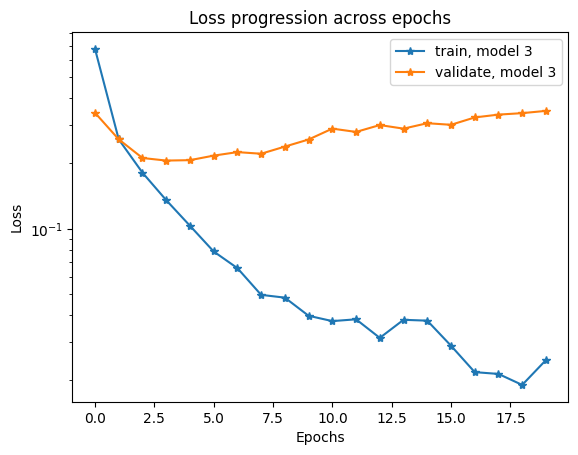

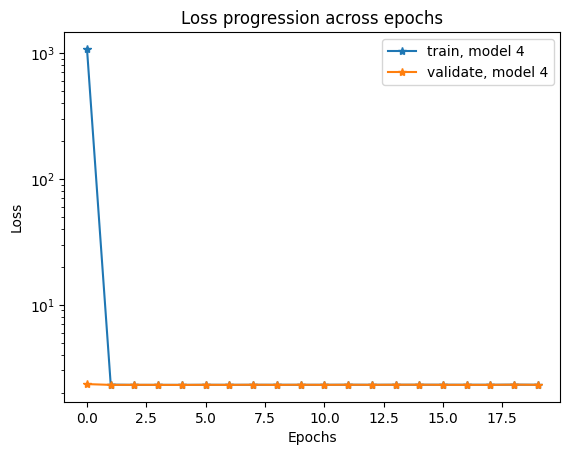

In [26]:
plot_losses(values_task1['tr_losses'],values_task1['val_losses'],all_in_one=False)

From these three plots, it is possible to draw the following conclusions:
* The SGD optimizer without the momentum converges slower than with the momentum. It is not suprising. As seen in the lecture, adding a momentum can improve the performances.
* The SGD optimizer converges to a solution, but in 20 epochs, it does not achieve the solution, since the loss is still decreasing
* The Adam optimizer with lr=0.01 converges faster than the SGD. In 20 epchos, it already achieves the solution since, there is a plateau in the loss. The accuracy on the validation set is higher than with the SGD.
* The Adam optimizer with lr=1 diverges. The accuracy of the validation set is arround 20\% which is really bad. It can therefore be concluded that a learning rate of 1 is too big for the Adam optimizer.

We should therefore choose the second model to achieve the best performance.

3.

In [35]:
# YOUR CODE HERE
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(576,1024)
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x

In [36]:
cnn1 = CNN().to(DEVICE)
cnn2 = CNN().to(DEVICE)
cnn3 = CNN().to(DEVICE)
cnn4 = CNN().to(DEVICE)
list_cnn = [cnn1,cnn2,cnn3,cnn4]

list_optimizers = [
    torch.optim.SGD(cnn1.parameters(), lr=0.01),
    torch.optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9,nesterov=True),
    torch.optim.Adam(cnn3.parameters(), lr=0.01),
    torch.optim.Adam(cnn4.parameters(), lr=1)
]

tr_losses, val_losses, valid_accs, te_loss_all, te_accs = test_models(
    list_cnn,
    list_optimizers,
    train_dataloader,
    valid_dataloader,
    test_dataloader,
    DEVICE
    )

****** Model 1 **************
Epoch 0: Train Loss=6.0228, Validation Loss=2.3813, Validation acc=23.8400
Epoch 1: Train Loss=2.0374, Validation Loss=1.8336, Validation acc=40.9600
Epoch 2: Train Loss=1.8067, Validation Loss=1.6249, Validation acc=48.7700
Epoch 3: Train Loss=1.6278, Validation Loss=1.4991, Validation acc=52.1200
Epoch 4: Train Loss=1.4785, Validation Loss=1.3268, Validation acc=57.4100
Epoch 5: Train Loss=1.3236, Validation Loss=1.2476, Validation acc=58.7700
Epoch 6: Train Loss=1.2306, Validation Loss=1.2724, Validation acc=54.3700
Epoch 7: Train Loss=1.1440, Validation Loss=1.0913, Validation acc=64.0400
Epoch 8: Train Loss=1.0584, Validation Loss=1.0453, Validation acc=64.4500
Epoch 9: Train Loss=0.9740, Validation Loss=1.0174, Validation acc=65.1300
Epoch 10: Train Loss=0.9110, Validation Loss=1.0002, Validation acc=65.1000
Epoch 11: Train Loss=0.8440, Validation Loss=0.8444, Validation acc=72.7900
Epoch 12: Train Loss=0.8216, Validation Loss=0.8053, Validation acc=

In [37]:
values_task2 = {
    'tr_losses':tr_losses,
    'val_losses':val_losses,
    'valid_accs':valid_accs,
    'te_loss_all':te_loss_all,
    'te_accs':te_accs
}

In [38]:
test_acc = [tensor.item() for tensor in te_accs]
model_names = ['model2.1', 'model2.2', 'model2.3', 'model2.4']
descriptions = ['SGD + lr=0.01',
                'SGD + lr=0.01+ momentum=0.9 + nesterov=True',
                'Adam + lr=0.01',
                'Adam + lr = 1'
                ]
model_type = ['CNN'] * 4
results_task2 = pd.DataFrame({'Model': model_names,
                              'Model Type':model_type,
                              'Accuracy': test_acc,
                              'Description':descriptions})

In [39]:
results_task2

,Model,Model Type,Accuracy,Description
0,model2.1,CNN,67.259995,SGD + lr=0.01
1,model2.2,CNN,89.470001,SGD + lr=0.01+ momentum=0.9 + nesterov=True
2,model2.3,CNN,90.309998,Adam + lr=0.01
3,model2.4,CNN,10.000000,Adam + lr = 1


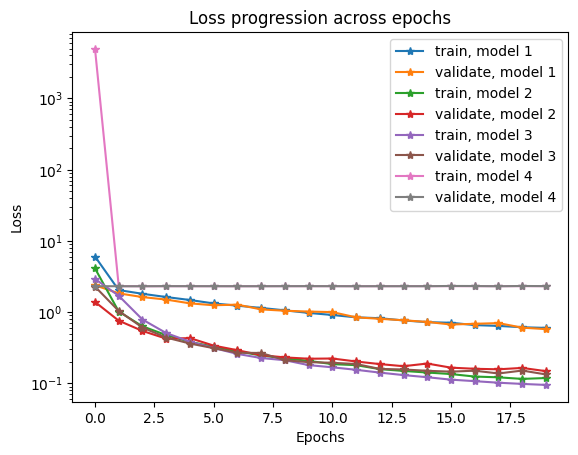

In [40]:
plot_losses(values_task2['tr_losses'],values_task2['val_losses'])

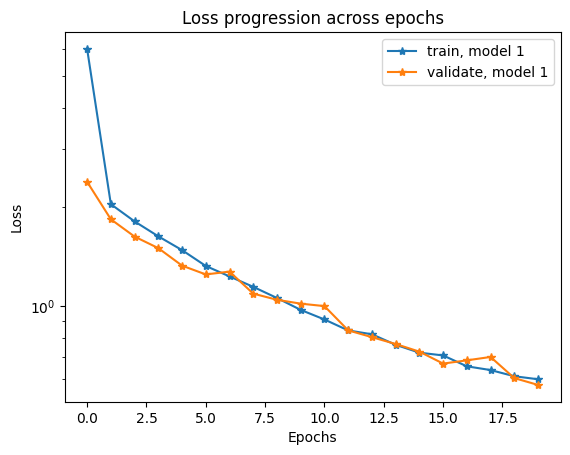

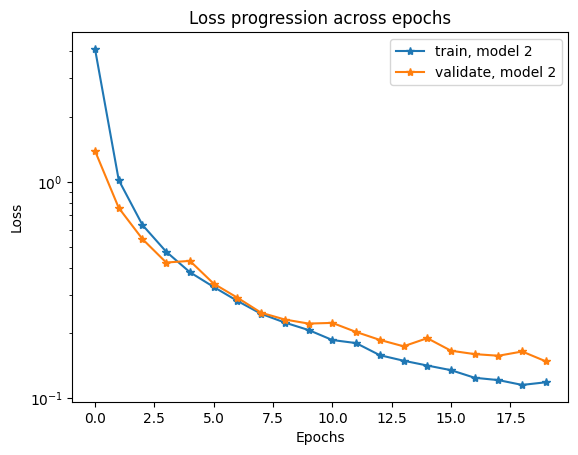

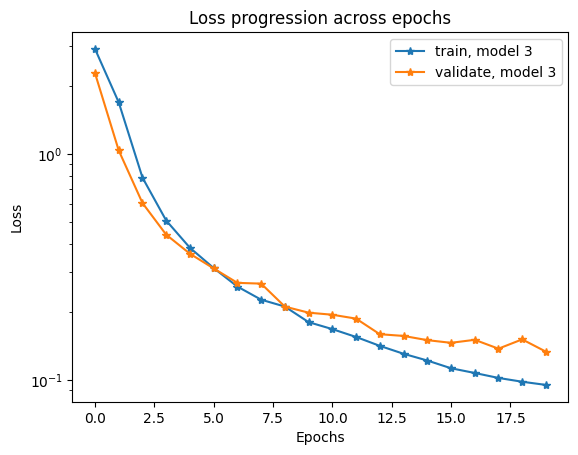

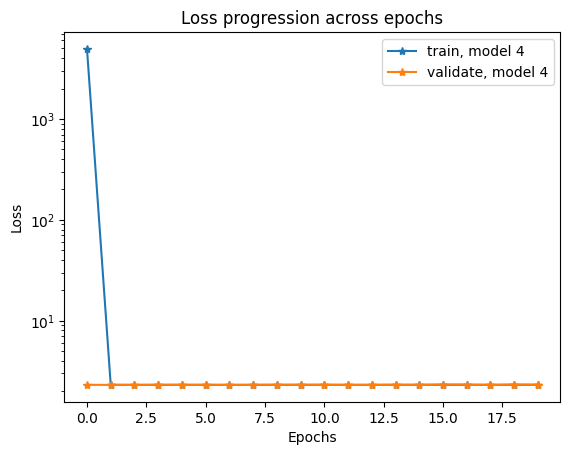

In [41]:
plot_losses(values_task2['tr_losses'],values_task2['val_losses'],all_in_one=False)

4.

In [42]:
from torchsummary import summary

def compute_nb_param(model):
  total_params = sum(p.numel() for p in model.parameters())
  return total_params

In [43]:
params_cnn = compute_nb_param(CNN())
params_mlp = compute_nb_param(MLP())

print(f'The number of parameters for CNN is : {params_cnn}')
print(f'The number of parameters for MLP is : {params_mlp}')

The number of parameters for CNN is : 614144
The number of parameters for MLP is : 89610


A fully connected neural network has typically much more parameters as a Convolutional Neural Network. In fact, in a MLP, every neuron learn every part of the image. But in a CNN, neurons learn only part of the image. With the previous, results, it's possible to conclude that the accuracy does not always increase with the number of parameters.

5.

In [44]:
class RandomPermutation(object):
  def __init__(self, num_features):
      self.num_features = num_features
      self.reindex = torch.randperm(num_features)
  def __call__(self, img):
      assert self.num_features == img.numel()
      orig_shape = img.shape
      img = img.view(-1)[self.reindex].view(orig_shape)
      return img

In [45]:
transform = torch.distributions.transforms.ComposeTransform(
    [
        torchvision.transforms.ToTensor(),
        RandomPermutation(28*28)
    ]
)
# load the train dataset
rdn_train_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
rdn_test_dataset = torchvision.datasets.KMNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(rdn_train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
rdn_train_dataset,  rdn_valid_dataset = random_split(
    rdn_train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(rdn_train_dataset)

Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ComposeTransform(
               ToTensor(),
           )


In [46]:
rdn_train_dataloader = DataLoader(
    dataset=rdn_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

rdn_valid_dataloader = DataLoader(
    dataset=rdn_valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

rdn_test_dataloader = DataLoader(
    dataset=rdn_test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

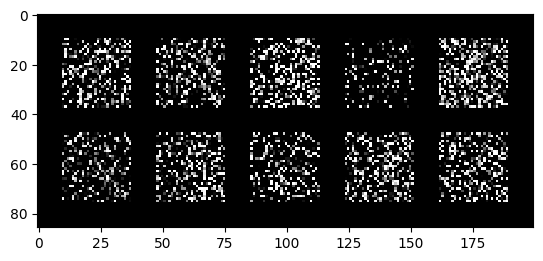

In [47]:
visualize_images(rdn_train_dataloader)

In [48]:
mlp = MLP().to(DEVICE)
cnn = CNN().to(DEVICE)
list_models = [mlp,cnn]

list_optimizers = [
    torch.optim.SGD(mlp.parameters(), lr=0.01, momentum=0.9,nesterov=True),
    torch.optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9,nesterov=True),
]
tr_losses, val_losses, valid_accs, te_loss_all, te_accs = test_models(
    list_models,
    list_optimizers,
    rdn_train_dataloader,
    rdn_valid_dataloader,
    rdn_test_dataloader,
    DEVICE
    )

****** Model 1 **************
Epoch 0: Train Loss=2.2601, Validation Loss=2.1565, Validation acc=44.1100
Epoch 1: Train Loss=1.8170, Validation Loss=1.4195, Validation acc=63.2000
Epoch 2: Train Loss=1.1385, Validation Loss=0.9322, Validation acc=72.7000
Epoch 3: Train Loss=0.8263, Validation Loss=0.7547, Validation acc=77.3200
Epoch 4: Train Loss=0.6967, Validation Loss=0.6655, Validation acc=79.7800
Epoch 5: Train Loss=0.6190, Validation Loss=0.6063, Validation acc=81.6300
Epoch 6: Train Loss=0.5654, Validation Loss=0.5648, Validation acc=82.9900
Epoch 7: Train Loss=0.5275, Validation Loss=0.5343, Validation acc=83.9900
Epoch 8: Train Loss=0.4972, Validation Loss=0.5111, Validation acc=84.6200
Epoch 9: Train Loss=0.4720, Validation Loss=0.4919, Validation acc=85.2600
Epoch 10: Train Loss=0.4499, Validation Loss=0.4736, Validation acc=85.8000
Epoch 11: Train Loss=0.4309, Validation Loss=0.4566, Validation acc=86.3700
Epoch 12: Train Loss=0.4138, Validation Loss=0.4430, Validation acc=

In [49]:
values_task5 = {
    'tr_losses':tr_losses,
    'val_losses':val_losses,
    'valid_accs':valid_accs,
    'te_loss_all':te_loss_all,
    'te_accs':te_accs
}

In [50]:
test_acc = [tensor.item() for tensor in te_accs]
model_names = ['model5.1', 'model5.2']
descriptions = ['SGD + lr=0.01+ momentum=0.9 + nesterov=True'] * 2
model_type = ['MLP','CNN']
results_task5 = pd.DataFrame({'Model': model_names,
                              'Model Type':model_type,
                              'Accuracy': test_acc,
                              'Description':descriptions})

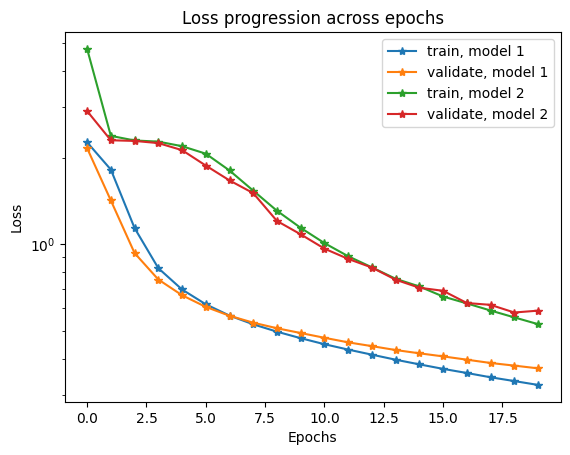

In [51]:
plot_losses(values_task5['tr_losses'],values_task5['val_losses'])

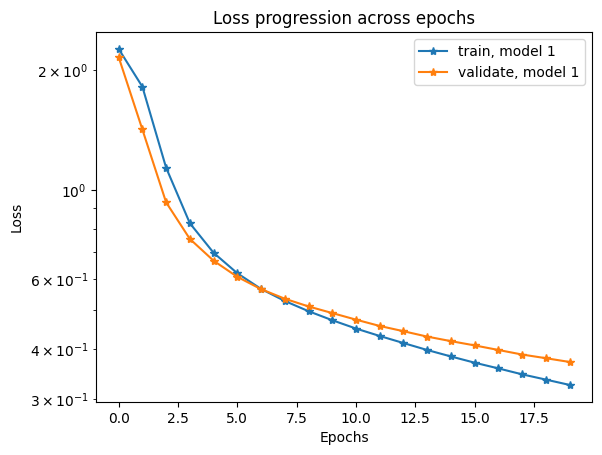

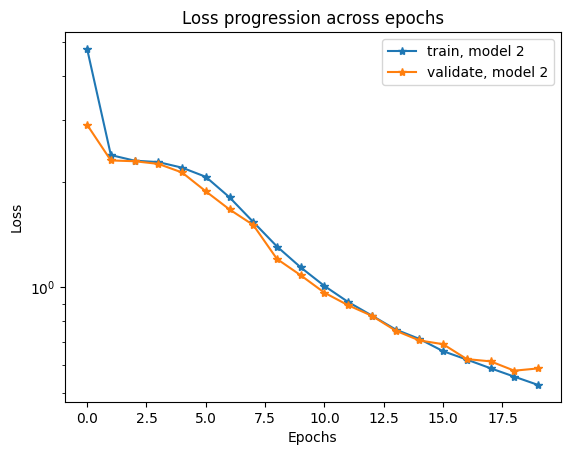

In [52]:
plot_losses(values_task5['tr_losses'],values_task5['val_losses'],all_in_one=False)

5. Bonus part

In [53]:
import torch
import torch.nn as nn

class AdvanceCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs pass through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Fully connected layer, output 10 classes
        self.out = nn.Linear(64 * 3 * 3, 10)  # Adjust the input size to match the output of the convolutional layers

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Reshape the tensor
        x = self.out(x)
        return x


In [54]:
model = AdvanceCNN().to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9,nesterov=True)

train_losses, valid_losses, valid_accs = fit(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE
)
test_loss_bonus1,test_acc_bonus1 = predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=0.7756, Validation Loss=0.6168, Validation acc=80.0800
Epoch 1: Train Loss=0.2618, Validation Loss=0.2254, Validation acc=93.9300
Epoch 2: Train Loss=0.1831, Validation Loss=0.1758, Validation acc=95.1400
Epoch 3: Train Loss=0.1442, Validation Loss=0.1487, Validation acc=95.8700
Epoch 4: Train Loss=0.1194, Validation Loss=0.1344, Validation acc=96.3300
Epoch 5: Train Loss=0.1021, Validation Loss=0.1236, Validation acc=96.4800
Epoch 6: Train Loss=0.0887, Validation Loss=0.1111, Validation acc=97.1400
Epoch 7: Train Loss=0.0783, Validation Loss=0.1061, Validation acc=96.9500
Epoch 8: Train Loss=0.0699, Validation Loss=0.1020, Validation acc=97.1700
Epoch 9: Train Loss=0.0627, Validation Loss=0.0969, Validation acc=97.3400
Epoch 10: Train Loss=0.0565, Validation Loss=0.0930, Validation acc=97.4800
Epoch 11: Train Loss=0.0513, Validation Loss=0.0884, Validation acc=97.4400
Epoch 12: Train Loss=0.0467, Validation Loss=0.0871, Validation acc=97.5700
Epoch 13: Train Loss=0

In [55]:
bonus_1 = {'Model':'bonus1',	'Model Type':'AdvancedCNN',	'Accuracy':test_acc_bonus1.item(),	'Description':'model with more layer'}

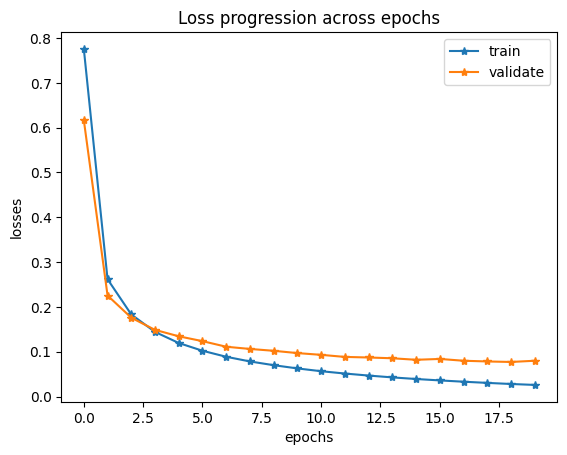

In [56]:
plt.plot(train_losses, '*-', label = 'train')
plt.plot(valid_losses, '*-', label = 'validate')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.title('Loss progression across epochs')
plt.legend()
plt.show()

In [57]:
class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [58]:
# initialize the model
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

train_losses, valid_losses, valid_accs = fit(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    epochs=20,
    device=DEVICE,
    scheduler = scheduler
)
test_loss_bonus2,test_acc_bonus2 = predict(model=model, test_dataloader=test_dataloader, device=DEVICE)


Epoch 0: Train Loss=1.0661, Validation Loss=0.3717, Validation acc=88.1900
Epoch 1: Train Loss=0.0954, Validation Loss=0.0974, Validation acc=97.2500
Epoch 2: Train Loss=0.0302, Validation Loss=0.0743, Validation acc=97.9500
Epoch 3: Train Loss=0.0116, Validation Loss=0.0734, Validation acc=97.5500
Epoch 4: Train Loss=0.0109, Validation Loss=0.0662, Validation acc=97.9500
Epoch 5: Train Loss=0.0062, Validation Loss=0.0590, Validation acc=98.2600
Epoch 6: Train Loss=0.0063, Validation Loss=0.0919, Validation acc=97.2300
Epoch 7: Train Loss=0.0130, Validation Loss=0.1787, Validation acc=94.8600
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8: Train Loss=0.0280, Validation Loss=0.1901, Validation acc=94.3300
Epoch 9: Train Loss=0.0068, Validation Loss=0.0331, Validation acc=98.9900
Epoch 10: Train Loss=0.0018, Validation Loss=0.0321, Validation acc=98.9900
Epoch 11: Train Loss=0.0011, Validation Loss=0.0314, Validation acc=99.1000
Epoch 12: Train Loss=0.0009, Validat

In [59]:
bonus_2 = {'Model':'bonus2',	'Model Type':'ResNet',	'Accuracy':test_acc_bonus2.item(),	'Description':'ResNet with scheduler'}

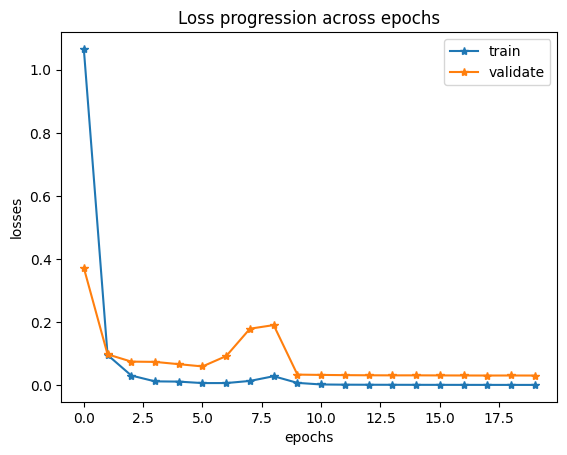

In [60]:
plt.plot(train_losses, '*-', label = 'train')
plt.plot(valid_losses, '*-', label = 'validate')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.title('Loss progression across epochs')
plt.legend()
plt.show()

In [61]:
results = pd.concat((results_task1,results_task2,results_task5))
results = results.append(bonus_1,ignore_index=True)
results = results.append(bonus_2,ignore_index=True)

In [62]:
results

,Model,Model Type,Accuracy,Description
0,model1.1,MLP,53.129997,SGD + lr=0.01
1,model1.2,MLP,78.290001,SGD + lr=0.01+ momentum=0.9 + nesterov=True
2,model1.3,MLP,88.110001,Adam + lr=0.01
3,model1.4,MLP,9.990000,Adam + lr = 1
4,model2.1,CNN,67.259995,SGD + lr=0.01
5,model2.2,CNN,89.470001,SGD + lr=0.01+ momentum=0.9 + nesterov=True
6,model2.3,CNN,90.309998,Adam + lr=0.01
7,model2.4,CNN,10.000000,Adam + lr = 1
8,model5.1,MLP,78.970001,SGD + lr=0.01+ momentum=0.9 + nesterov=True
9,model5.2,CNN,68.029999,SGD + lr=0.01+ momentum=0.9 + nesterov=True
